# Brainhack 2019 - starter kit

By [Piotr Migdał](https://p.migdal.pl) and Katarzyna Kańska.


## Notebook 1: Simple networks for image classification
We will use a subset of [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset).

Conveniet way to download selected classes (using [gsutil](https://cloud.google.com/storage/docs/gsutil_install)) `gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" .`

See: https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.utils import data
import torchvision
from torchvision import datasets, transforms

from livelossplot import PlotLosses

In [3]:
torch.manual_seed(42)

## Data loading

In [4]:
with open('google_draw/categories.txt') as f:
    classes = [line.strip() for line in f.readlines()]

classes

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cello',
 'cell phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [7]:
classes = ["apple", "spider", "octopus", "snowflake"]
limit = 500
images = []

for label in classes:
    X = np.load('google_draw/full_numpy_bitmap_{}.npy'.format(label))
    print("Loaded {} out of {} {}s".format(limit, X.shape[0], label))
    images.append(X[:limit])

X = np.concatenate(images)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 500 out of 144722 apples
Loaded 500 out of 209447 spiders
Loaded 500 out of 150152 octopuss
Loaded 500 out of 116685 snowflakes


In [8]:
X.shape

(2000, 784)

In [9]:
X.dtype

dtype('uint8')

In [10]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  11,  21,  12,   0,   0,   0,   0,   0,   0,   0,
         0,  92,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  91, 213, 253, 255, 255, 222,  95,   3,   0,   0,
         0,   0,   7, 255, 222,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  24, 190, 255, 196, 118, 100, 109, 196, 255, 121,
         0,   0,   0,   0,   0, 141,  35,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1, 185, 241,  94,   1,   0,   0,   0,   0,
        63,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  89, 255, 115, 133, 150,  37,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 207, 241, 252, 25

In [11]:
X = X.reshape(-1, 1, 28, 28)
X = X.astype('float32') / 255.
X = np.pad(X, [(0, 0), (0, 0), (2, 2), (2, 2)], mode='constant')

# (samples, channels, x, y)
X.shape

(2000, 1, 32, 32)

In [12]:
# answer keys are integers
Y.dtype

dtype('int32')

### Let's have a look

In [13]:
def draw_examples(X, Y, classes, rows=6, scale=1):
    fig, axs = plt.subplots(rows, len(classes), figsize=(scale * len(classes), scale * rows))
    size = X.shape[-1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        for i in range(rows):
            ax = axs[i, class_id]
            x = X_class[np.random.randint(len(X_class))].reshape(size, size)
            ax.imshow(x, cmap='Greys', interpolation='none')
            ax.axis('off')

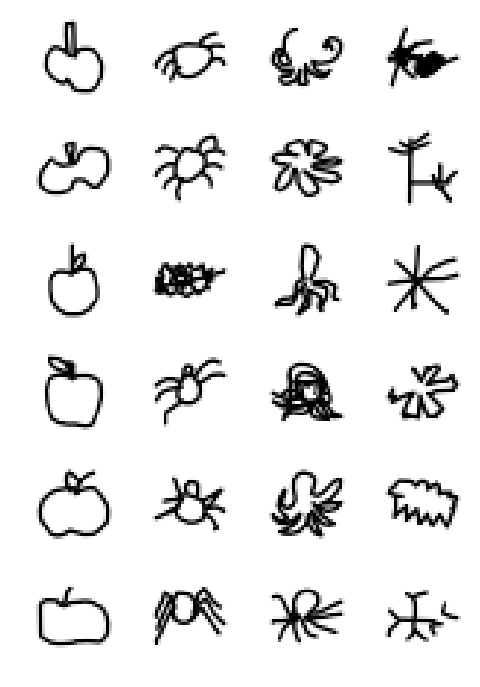

In [14]:
draw_examples(X, Y, classes, rows=6, scale=2)

## Train-test split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## Datasets and data loaders

We need to create data loaders to load and preprocess data. We use split:
* train - for training,
* validation - not used for training, but to evaluate model performance.

In [16]:
# define data loaders
dataloaders = {
    'train':
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).long()),
        batch_size=64,
        shuffle=True, num_workers=4
    ),
    'validation': 
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).long()),
        batch_size=64,
        shuffle=False, num_workers=4
    )
}

## Before we start

While training a model, it is important to set `train` or `eval` mode of the model, as some layers have different behavior during train and evaluation.

See also: [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning) which explains API differences between these frameworks.

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()
    return model

In [18]:
device

device(type='cpu')

## Convolutional neural network

Treating an image as a flat vector looses its spatial structure. Instead we can use the spacial structure in our advantage and perform convolutions.
Convolution is an operation which performs the same local operation on each part of the image.

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true)

Each convolution layer produces new channels based on those which preceded it. First, we start with 3 channels for red, green and blue (RGB) components. Next, channels get more and more abstract.

While producing new channels with representations of various properties of the image, we also reduce the resolution, usually using pooling layers.

See also:
* [Image Kernels - visually explained](http://setosa.io/ev/image-kernels/)
* [How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)
* source of above image: [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)
* [Convolutional Neural Networks by Andrej Karpathy](http://cs231n.github.io/convolutional-networks/) for in-depth explanation of convolutions and other accompanying blocks

In [19]:
# antipattern in PyTorch, don't do it!
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self._conv_block(1, 16)
        self.conv2 = self._conv_block(16, 32)
        self.conv3 = self._conv_block(32, 64)
        
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, len(classes))
        )
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [21]:
def make_connector(in_channels, out_channels, intermediate_channels=None):
    if not intermediate_channels:
        intermediate_channels = in_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True),
        nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [22]:
class SewnConvNet(nn.Module):
    def __init__(self, net_before, net_after, connector):
        super().__init__()
        self.net_before = net_before.eval()
        self.net_after = net_after.eval()
        self.connector = connector
        
        self._assert_channels()
    
    def forward(self, x):
        x = self.net_before(x)
        x = self.connector(x)
        x = self.net_after(x)
        return x
    
    def _assert_channels(self):
        '''
        net_before, net_after, connector - nn.Sequential or nn.ModuleList
        '''
        before_out_channels = self._find_out_channels(self.net_before)
        connector_in_channels = self._find_in_channels(self.connector)
        if before_out_channels != connector_in_channels:
            raise ValueError('Connector has {} input channels, expected {}.'.format(
                connector_in_channels, before_out_channels)
            )
        
        connector_out_channels = self._find_out_channels(self.connector)
        after_in_channels = self._find_in_channels(self.net_after)
        if after_in_channels != connector_out_channels:
            raise ValueError('Connector has {} output channels, expected {}.'.format(
                connector_out_channels, after_in_channels)
            )
    
    def parameters(self, recurse=True):
        return self.connector.parameters()
    
    def train(self, mode=True):
        self.training = mode
        self.connector.train(mode)
        return self
    
    def eval(self):
        return self.train(False)
    
    def _find_in_channels(self, half):
        for m in half.modules():
            if isinstance(m, nn.Conv2d):
                return m.in_channels
            if isinstance(m, nn.Linear):
                return m.in_features
    
    def _find_out_channels(self, half):
        out_channels = None
        for m in half.modules():
            if isinstance(m, nn.Conv2d):
                out_channels = m.out_channels
            if isinstance(m, nn.Linear):
                out_channels = m.out_features
        return out_channels

In [23]:
model1 = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

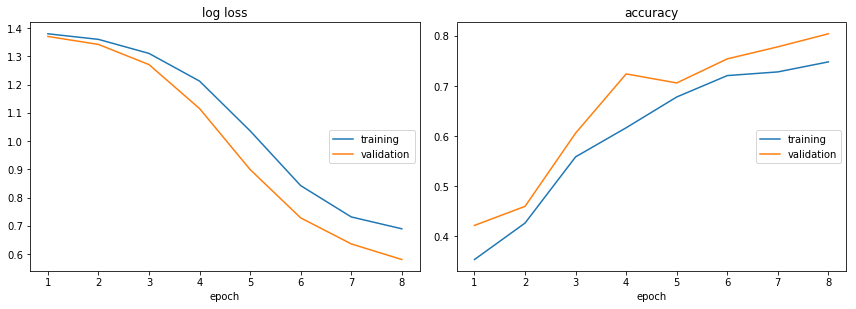

log loss:
training   (min:    0.689, max:    1.380, cur:    0.689)
validation (min:    0.581, max:    1.370, cur:    0.581)

accuracy:
training   (min:    0.354, max:    0.748, cur:    0.748)
validation (min:    0.422, max:    0.804, cur:    0.804)


In [ ]:
model1_trained = train_model(model1, criterion, optimizer1, num_epochs=20)

## Implant layer into one trained network

In [ ]:
net_before = nn.Sequential(
    model1.conv1,
    model1.conv2,
)

net_after = nn.Sequential(
    model1.conv3,
    model1.fc
)

connector = make_connector(32, 32)

In [ ]:
sewn_model1 = SewnConvNet(net_before, net_after, connector)
optimizer = optim.Adam(sewn_model1.parameters(), lr=1e-4)

sewn_model1_trained = train_model(sewn_model1, criterion, optimizer, num_epochs=20)

## Sew two trained networks

In [ ]:
model2 = ConvNet()
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)

model2_trained = train_model(model2, criterion, optimizer2, num_epochs=20)

In [ ]:
net_before = nn.Sequential(
    model1.conv1,
    model1.conv2,
)

net_after = nn.Sequential(
    model2.conv3,
    model2.fc
)

connector = make_connector(32, 32)

In [ ]:
sewn_model2 = SewnConvNet(net_before, net_after, connector)
optimizer = optim.Adam(sewn_model2.parameters(), lr=1e-4)

sewn_model2_trained = train_model(sewn_model2, criterion, optimizer, num_epochs=20)

In [ ]:
# dla chetnych:
#
# def _weights_init(model):
#     def weights_init(m):
#         if isinstance(m, nn.Linear):
#             nn.init.xavier_uniform_(m.weight.data)
#             nn.init.zeros_(m.bias.data)

#     model.apply(weights_init)